##MLP with TF Tuner implementation

In [ ]:
!pip install tensorflow
!pip install -q -U keras-tuner
import pandas as pd
import numpy as np


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.7/135.7 KB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 25.4 MB/s eta 0:00:00


In [ ]:
files=np.load('/content/drive/MyDrive/Data/689PolynomialData/ae_data.npz')
for k in files:
  print(k)

Str
Xtr
Ytr
Ste
Xte
Yte


In [ ]:
files['Ytr'][0],files['Str'][20:40]

(array([-188.]),
 array(['    9-8', '  1+489', '    6+1', ' 239+53', '   2+78', '   5-40',
        '    4+9', '  7+273', ' 349-44', '  73+40', '205+152', '    7-5',
        '  59-31', ' 696-70', '   47+7', '    7-8', '   87-0', '   1+69',
        '  304-8', ' 78-550'], dtype='<U7'))

In [ ]:
word2idx={'':0,'+':1,'-':2}
charset=set() #sorted(set(files['Str']))
for val in files['Str']:
  for e in val: charset.add(e)
word2idx={word:idx for idx, word in enumerate(sorted(charset))}

In [ ]:
def tokenize(data):
  return [word2idx[i] for i in data]
X=[tokenize(val) for val in files['Str']]
X=np.array(X)
y=np.array(files['Ytr'])

In [ ]:
X=X[:5000]
y=y[:5000]

In [ ]:
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2,l1
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.metrics import AUC
import keras_tuner as kt

def model_builder(hp):
  model=Sequential()
  model.add(Dense(7,input_shape=(7,),activation='relu',kernel_regularizer=l2(0.001)))
  model.add(BatchNormalization())
  model.add(Dropout(0.15))
  model.add(Dense(hp.Int('hidden_size', 30, 100, step=10, default=50),activation='relu'))
  # model.add(BatchNormalization())
  model.add(Dropout(0.3))
  model.add(Dense(12,activation='relu',kernel_regularizer=l1(0.001)))
  # model.add(BatchNormalization())
  model.add(Dropout(0.2))
  model.add(Dense(1))
  hp_learning_rate = hp.Choice('learning_rate', values=[0.01,0.001,0.0001,0.00001])
  optimizer = Adam(lr=hp_learning_rate, decay=5e-4)
  model.compile(optimizer=optimizer, loss='mae')
  return model
# history=model.fit(X, y, epochs=50, validation_split=0.2, batch_size=8)

##Implementing TF tuner for hyperparameter tuning

In [ ]:
tuner = kt.Hyperband(model_builder,
                     objective=kt.Objective('val_loss',direction="min"),
                     max_epochs=10,
                     factor=3,
                     directory='my_dir',
                     project_name='intro_to_kt')
stop_early = EarlyStopping(monitor='val_loss', patience=5)
tuner.search(X, y, epochs=10, validation_split=0.2, callbacks=[stop_early])

# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

In [ ]:
best_hps.values

{'hidden_size': 30,
 'learning_rate': 0.01,
 'tuner/epochs': 10,
 'tuner/initial_epoch': 0,
 'tuner/bracket': 0,
 'tuner/round': 0}

In [ ]:
model = tuner.hypermodel.build(best_hps)
history = model.fit(X, y, epochs=50, validation_split=0.2)

val_acc_per_epoch = history.history['val_loss']
best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))

Epoch 1/50
125/125 [==============================] - 1s 4ms/step - loss: 168088.0312 - val_loss: 133251.1406
Epoch 2/50
125/125 [==============================] - 0s 3ms/step - loss: 143873.3281 - val_loss: 132857.6094
Epoch 3/50
125/125 [==============================] - 0s 3ms/step - loss: 138589.9219 - val_loss: 126886.8438
Epoch 4/50
125/125 [==============================] - 0s 3ms/step - loss: 139480.8438 - val_loss: 127596.5781
Epoch 5/50
125/125 [==============================] - 0s 3ms/step - loss: 136603.7344 - val_loss: 125184.0781
Epoch 6/50
125/125 [==============================] - 0s 3ms/step - loss: 137007.6406 - val_loss: 123711.9844
Epoch 7/50
125/125 [==============================] - 0s 3ms/step - loss: 138104.9531 - val_loss: 124451.0703
Epoch 8/50
125/125 [==============================] - 0s 3ms/step - loss: 138102.9531 - val_loss: 123321.4062
Epoch 9/50
125/125 [==============================] - 0s 3ms/step - loss: 134512.2031 - val_loss: 125478.5156
Epoch 10/5

2813/2813 [==============================] - 4s 1ms/step


(array([[102.95554 ,  26.057236,  81.61793 , 122.64572 , 631.4146  ,
         284.43817 ,  26.057236,  26.057236, 659.8656  , 279.8784  ]],
       dtype=float32),
 array([[-188.,   18.,  165., -504.,  889.,  352.,    6.,    9.,  943.,
          204.]]))

##RNN model

In [ ]:
!pip install torch
import torch
import torch.nn as nn



Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
train_len=int(0.9*len(X))
print("training length:",train_len)

train_inputs=torch.tensor(X[:train_len])
# train_masks=torch.tensor(attention_mask[:train_len])
train_label=torch.tensor(y[:train_len])
val_inputs=torch.tensor(X[train_len:])
# val_masks=torch.tensor(attention_mask[train_len:])
val_label=torch.tensor(y[train_len:])

training length: 58320


In [ ]:
#create tensor datasets
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

batch_size = 128

# Create the DataLoader for our training set.
train_data = TensorDataset(train_inputs, train_label)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size,drop_last=True)

# Create the DataLoader for our validation set.
validation_data = TensorDataset(val_inputs, val_label)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size,drop_last=True)

In [ ]:
import torch.nn as nn
devide="cpu"
class RNNModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim, dropout_prob):
        super(RNNModel, self).__init__()

        # Defining the number of layers and the nodes in each layer
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim

        # RNN layers
        self.rnn = nn.RNN(
            input_dim, hidden_dim, layer_dim, batch_first=True, dropout=dropout_prob,
            # nonlinearity='relu'
            # bidirectional=True
        )
        # Fully connected layer
        self.fc = nn.Linear(hidden_dim, 32)
        self.relu=nn.ReLU()
        self.fc1 = nn.Linear(32, 8)
        self.relu1=nn.ReLU()
        self.fc2=nn.Linear(8, output_dim)
        self.sigmoid=nn.Softmax()

    def forward(self, x):
        # x=x.unsqueeze(0)
        # Initializing hidden state for first input with zeros

        h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).requires_grad_()
        h0=h0.to(device)
        h0=h0.to(torch.float32)
        x=x.to(torch.float32)
        x=x.to(device)

        # Forward propagation by passing in the input and hidden state into the model
        out, h0 = self.rnn(x, h0)

        # Reshaping the outputs in the shape of (batch_size, seq_length, hidden_size)
        # so that it can fit into the fully connected layer
        out = out[: , -1, :]
        # return self.fc(out)
        # return self.fc1(self.relu(self.fc(out)))
        # Convert the final state to our desired output shape (batch_size, output_dim)
        out = self.fc2(self.relu1(self.fc1(self.relu(self.fc(out)))))
        return out

        # out=self.sigmoid(out)
        # return out[-1]


In [ ]:
#Adam optimizer with weigth decay fixes
import torch.optim as optim
# from warmup_scheduler_pytorch import WarmUpScheduler
model=RNNModel(7,7,3,1,0.1)
optimizer = optim.AdamW(model.parameters(),
                  lr = 0.001 , # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  # eps = 1e-8, # args.adam_epsilon  - default is 1e-8.
                  weight_decay=0.001

                )
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, factor=0.1, patience=15, verbose=True
)
# scheduler_warmup = WarmUpScheduler(optimizer, multiplier=1, total_epoch=5, after_scheduler=scheduler)

# from transformers import get_linear_schedule_with_warmup

# Number of training epochs (authors recommend between 2 and 4)
epochs = 8
device="cpu"
# Total number of training steps is number of batches * number of epochs.
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
# scheduler_warmup = get_linear_schedule_with_warmup(optimizer,
#                                             num_warmup_steps = 5, # Default value in run_glue.py
#                                             num_training_steps = total_steps)
scheduler

In [ ]:
def lossFunction(predicted,target):
  loss = nn.L1Loss(reduction='mean')
  return loss(predicted,target)
tr_loss_hist = []


model.train()
model.to(device)
for e in range(150):
    avg_tr_loss = []
    tr_step = 0

    for step,batch in enumerate(train_dataloader):
        input,label=batch
        x_batch = input.view([batch_size, -1, 7]).to(device)
        y_batch = label.to(device)
        y_batch=y_batch.to(torch.float32)
        predicted=model(x_batch)

        loss=lossFunction(predicted,y_batch)
        avg_tr_loss.append(loss.item())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        tr_step += 1

    atl=sum(avg_tr_loss)/ tr_step
    # scheduler.step(atl)
    tr_loss_hist.append(atl)

    if (e + 1) % 2 == 0:
        print('Epoch: {:3}, tr_loss: {:.3f}'.format(e+1, atl))

Epoch:   2, tr_loss: 226.627
Epoch:   4, tr_loss: 189.183
Epoch:   6, tr_loss: 170.296
Epoch:   8, tr_loss: 165.633
Epoch:  10, tr_loss: 161.580
Epoch:  12, tr_loss: 160.019
Epoch:  14, tr_loss: 156.660
Epoch:  16, tr_loss: 152.372
Epoch:  18, tr_loss: 142.985
Epoch:  20, tr_loss: 129.768
Epoch:  22, tr_loss: 123.630
Epoch:  24, tr_loss: 120.423
Epoch:  26, tr_loss: 118.487
Epoch:  28, tr_loss: 114.768
Epoch:  30, tr_loss: 111.457
Epoch:  32, tr_loss: 107.907
Epoch:  34, tr_loss: 104.736
Epoch:  36, tr_loss: 102.520
Epoch:  38, tr_loss: 100.491
Epoch:  40, tr_loss: 99.905
Epoch:  42, tr_loss: 98.813
Epoch:  44, tr_loss: 97.388
Epoch:  46, tr_loss: 97.960
Epoch:  48, tr_loss: 96.032
Epoch:  50, tr_loss: 96.258
Epoch:  52, tr_loss: 95.065
Epoch:  54, tr_loss: 94.958
Epoch:  56, tr_loss: 95.399
Epoch:  58, tr_loss: 95.160
Epoch:  60, tr_loss: 96.062
Epoch:  62, tr_loss: 93.586
Epoch:  64, tr_loss: 95.381
Epoch:  66, tr_loss: 94.109
Epoch:  68, tr_loss: 94.054
Epoch:  70, tr_loss: 92.809
E

In [ ]:
model.eval()
avg_val_loss=[]
for step,batch in enumerate(validation_dataloader):
        input,label=batch
        x_batch = input.view([batch_size, -1, 7]).to(device)
        y_batch = label.to(device)
        y_batch=y_batch.to(torch.float32)

        predicted=model(x_batch)
        # print(predicted)
        print(predicted[:1].T,y_batch[:1].T)
        loss=lossFunction(predicted,y_batch)


        avg_val_loss.append(loss.item())
print("Testing Loss: ",sum(avg_val_loss)/len(validation_dataloader))


tensor([[-190.4073]], grad_fn=<PermuteBackward0>) tensor([[-581.]])
tensor([[56.6208]], grad_fn=<PermuteBackward0>) tensor([[107.]])
tensor([[-105.2260]], grad_fn=<PermuteBackward0>) tensor([[-494.]])
tensor([[306.9487]], grad_fn=<PermuteBackward0>) tensor([[168.]])
tensor([[66.2376]], grad_fn=<PermuteBackward0>) tensor([[21.]])
tensor([[68.3400]], grad_fn=<PermuteBackward0>) tensor([[27.]])
tensor([[107.1077]], grad_fn=<PermuteBackward0>) tensor([[125.]])
tensor([[56.7961]], grad_fn=<PermuteBackward0>) tensor([[71.]])
tensor([[724.0518]], grad_fn=<PermuteBackward0>) tensor([[847.]])
tensor([[45.5454]], grad_fn=<PermuteBackward0>) tensor([[92.]])
tensor([[511.7805]], grad_fn=<PermuteBackward0>) tensor([[506.]])
tensor([[1072.7306]], grad_fn=<PermuteBackward0>) tensor([[1171.]])
tensor([[-4.0922]], grad_fn=<PermuteBackward0>) tensor([[-76.]])
tensor([[631.8201]], grad_fn=<PermuteBackward0>) tensor([[529.]])
tensor([[3.5574]], grad_fn=<PermuteBackward0>) tensor([[-37.]])
tensor([[3.5201]

[116.40690612792969, 97.07472229003906, 86.08900451660156, 100.45944213867188, 105.84500122070312, 73.92386627197266, 75.3816909790039, 90.26432800292969, 67.86396026611328, 67.1230697631836, 85.47012329101562, 84.36009216308594, 79.07967376708984, 105.94126892089844, 85.95511627197266, 82.20992279052734, 96.68620300292969, 105.21898651123047, 104.32254791259766, 69.22174072265625, 103.23612976074219, 88.18685913085938, 73.77986907958984, 87.15571594238281, 87.29093170166016, 86.69891357421875, 88.49838256835938, 71.73114013671875, 80.19339752197266, 75.4971694946289, 86.04631805419922, 106.73442840576172, 95.76499938964844, 78.83285522460938, 85.38690185546875, 88.41508483886719, 76.56358337402344, 90.1668701171875, 87.41426086425781, 90.76940155029297, 69.48397064208984, 87.03263854980469, 94.20161437988281, 107.88783264160156, 100.16096496582031, 119.01901245117188, 90.57124328613281, 101.61531066894531, 93.77882385253906, 81.40139770507812]


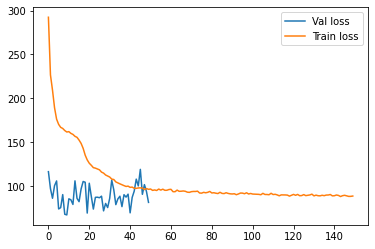

In [ ]:
from matplotlib import pyplot as plt
print(avg_val_loss)
plt.plot(avg_val_loss,label = "Val loss")
plt.plot(tr_loss_hist,label = "Train loss")
plt.legend()
plt.show()

In [ ]:
yhat

##MLP Implementation

In [ ]:
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2,l1
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.metrics import AUC
from tensorflow.keras.initializers import GlorotNormal
import keras_tuner as kt

def model_builder():
  model=Sequential()
  model.add(Dense(7,input_shape=(7,),activation='relu',kernel_initializer = GlorotNormal()))
  # model.add(BatchNormalization())
  # model.add(Dropout(0.15))
  # model.add(Dense(16,activation='relu',kernel_regularizer=l2(0.001)))
  model.add(Dense(64,activation='relu',kernel_initializer = GlorotNormal()))
  # model.add(BatchNormalization())
  # model.add(Dropout(0.3))
  model.add(Dense(32,activation='relu',kernel_initializer = GlorotNormal()))
  model.add(Dense(8,activation='relu',kernel_initializer = GlorotNormal()))
  # model.add(BatchNormalization())
  # model.add(Dropout(0.2))
  model.add(Dense(1))
  # hp_learning_rate = hp.Choice('learning_rate', values=[0.01,0.001,0.0001,0.00001])
  # optimizer = Adam(lr=0.01, decay=5e-4)
  optimizer = Adam(lr=0.02)
  model.compile(optimizer=optimizer, loss='mae')
  return model
# history=model.fit(X, y, epochs=70, validation_split=0.2, batch_size=8)

In [ ]:
from sklearn.model_selection import train_test_split

X,X_test,y,y_test=train_test_split(X,y,shuffle=True,test_size=0.1)

In [ ]:
model=model_builder()
history = model.fit(X, y, epochs=60, validation_split=0.2, batch_size=64)

Epoch 1/60


/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


810/810 [==============================] - 3s 3ms/step - loss: 205.2912 - val_loss: 180.2156
Epoch 2/60
810/810 [==============================] - 2s 2ms/step - loss: 167.3069 - val_loss: 125.3339
Epoch 3/60
810/810 [==============================] - 2s 3ms/step - loss: 70.9437 - val_loss: 45.0572
Epoch 4/60
810/810 [==============================] - 2s 2ms/step - loss: 30.6064 - val_loss: 23.1842
Epoch 5/60
810/810 [==============================] - 2s 2ms/step - loss: 27.4832 - val_loss: 19.4870
Epoch 6/60
810/810 [==============================] - 2s 2ms/step - loss: 23.6713 - val_loss: 18.5387
Epoch 7/60
810/810 [==============================] - 2s 2ms/step - loss: 21.8057 - val_loss: 24.0340
Epoch 8/60
810/810 [==============================] - 2s 2ms/step - loss: 19.0844 - val_loss: 21.4603
Epoch 9/60
810/810 [==============================] - 2s 2ms/step - loss: 34.2444 - val_loss: 21.8358
Epoch 10/60
810/810 [==============================] - 2s 2ms/step - loss: 18.4702 - val_

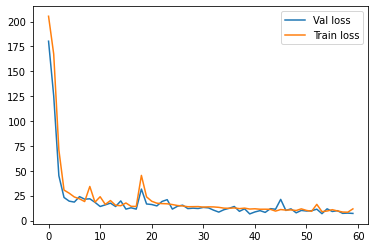

In [ ]:
tr_loss_hist=history.history['loss']
avg_val_loss=history.history['val_loss']
from matplotlib import pyplot as plt
plt.plot(avg_val_loss,label = "Val loss")
plt.plot(tr_loss_hist,label = "Train loss")
plt.legend()
plt.show()

In [ ]:
yhat=model.predict(X_test)
# print(yhat[:10],y_test[:10])

from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
score = r2_score(y_test, yhat)
mse_loss=mean_absolute_error(y_test, yhat)
score,mse_loss

225/225 [==============================] - 0s 2ms/step


(0.9993223135663057, 7.149539991948339)